In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and model evaluation tools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, silhouette_score)
from sklearn.decomposition import PCA

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Clustering models
from sklearn.cluster import KMeans, AgglomerativeClustering


In [3]:
# Load the dataset
df = pd.read_csv("/Users/prathameshkulkarni/Downloads/american_bankruptcy.csv")

# Display first few rows (optional)
print("Dataset preview:")
print(df.head())

Dataset preview:
  company_name status_label  year       X1       X2      X3      X4       X5  \
0          C_1        alive  1999  511.267  833.107  18.373  89.031  336.018   
1          C_1        alive  2000  485.856  713.811  18.577  64.367  320.590   
2          C_1        alive  2001  436.656  526.477  22.496  27.207  286.588   
3          C_1        alive  2002  396.412  496.747  27.172  30.745  259.954   
4          C_1        alive  2003  432.204  523.302  26.680  47.491  247.245   

       X6       X7  ...        X9      X10      X11     X12      X13      X14  \
0  35.163  128.348  ...  1024.333  740.998  180.447  70.658  191.226  163.816   
1  18.531  115.187  ...   874.255  701.854  179.987  45.790  160.444  125.392   
2 -58.939   77.528  ...   638.721  710.199  217.699   4.711  112.244  150.464   
3 -12.410   66.322  ...   606.337  686.621  164.658   3.573  109.590  203.575   
4   3.504  104.661  ...   651.958  709.292  248.666  20.811  128.656  131.261   

       X15     

In [4]:
# Encode the target variable. Assuming 'status_label' contains strings like "alive" and "bankrupt".
label_encoder = LabelEncoder()
df['status_encoded'] = label_encoder.fit_transform(df['status_label'])
# Note: Check label mapping with: dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nLabel mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label mapping: {'alive': 0, 'failed': 1}


In [5]:

# Use only the financial ratio features (assuming columns X1 to X18)
feature_columns = [f"X{i}" for i in range(1, 19)]
X = df[feature_columns].copy()
y = df['status_encoded'].copy()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.2, random_state=42)
print("\nData split completed: Training samples = {}, Test samples = {}".format(X_train.shape[0], X_test.shape[0]))


Data split completed: Training samples = 62945, Test samples = 15737


In [6]:

# ====================
# 2. Classification Models
# ====================
# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


In [7]:
# Function to train, predict and evaluate a model
def evaluate_model(model, X_tr, X_te, y_tr, y_te):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    acc = accuracy_score(y_te, preds)
    prec = precision_score(y_te, preds, average='binary')
    rec = recall_score(y_te, preds, average='binary')
    f1 = f1_score(y_te, preds, average='binary')
    conf = confusion_matrix(y_te, preds)
    return acc, prec, rec, f1, conf

In [8]:

# Evaluate each model and store results
results = {}
for name, model in classifiers.items():
    acc, prec, rec, f1, conf = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1, "Confusion Matrix": conf}
    print(f"\n{name} Results:")
    print("Accuracy: {:.4f}".format(acc))
    print("Precision: {:.4f}".format(prec))
    print("Recall: {:.4f}".format(rec))
    print("F1-Score: {:.4f}".format(f1))
    print("Confusion Matrix:\n", conf)


Logistic Regression Results:
Accuracy: 0.9322
Precision: 0.5385
Recall: 0.0066
F1-Score: 0.0130
Confusion Matrix:
 [[14663     6]
 [ 1061     7]]

Decision Tree Results:
Accuracy: 0.8923
Precision: 0.2243
Recall: 0.2388
F1-Score: 0.2313
Confusion Matrix:
 [[13787   882]
 [  813   255]]

Random Forest Results:
Accuracy: 0.9363
Precision: 0.9333
Recall: 0.0655
F1-Score: 0.1225
Confusion Matrix:
 [[14664     5]
 [  998    70]]

SVM Results:
Accuracy: 0.9325
Precision: 1.0000
Recall: 0.0056
F1-Score: 0.0112
Confusion Matrix:
 [[14669     0]
 [ 1062     6]]

k-NN Results:
Accuracy: 0.9402
Precision: 0.6721
Recall: 0.2322
F1-Score: 0.3452
Confusion Matrix:
 [[14548   121]
 [  820   248]]

XGBoost Results:
Accuracy: 0.9361
Precision: 0.6962
Recall: 0.1030
F1-Score: 0.1794
Confusion Matrix:
 [[14621    48]
 [  958   110]]


In [9]:

# ====================
# 3. Clustering Analysis
# ====================
# We use the scaled features (financial ratios) for clustering
# -- K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print("\nK-Means Silhouette Score: {:.4f}".format(kmeans_silhouette))

/Users/prathameshkulkarni/Desktop/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



K-Means Silhouette Score: 0.9126


In [10]:
# Add clustering results to dataframe for visualization
df['KMeans_cluster'] = kmeans_labels


In [11]:
# Visualize clusters using PCA (2D projection)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0, 0.5, 'PCA Component 2')

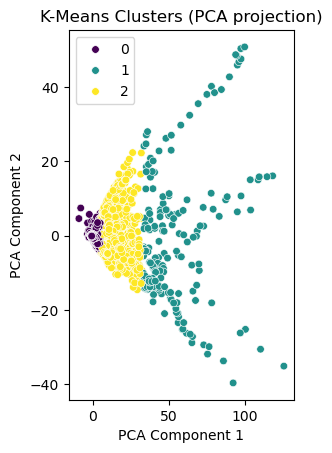

In [12]:


# K-Means cluster plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_labels, palette='viridis', legend='full', s=30)
plt.title("K-Means Clusters (PCA projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

In [13]:
cluster_feature = kmeans_labels.reshape(-1, 1)

X_hybrid = np.hstack([X_scaled, cluster_feature])


Xh_train, Xh_test, yh_train, yh_test = train_test_split(X_hybrid, y,
                                                        test_size=0.2, random_state=42)

print("\nHybrid model data split: Training samples = {}, Test samples = {}".format(Xh_train.shape[0], Xh_test.shape[0]))


Hybrid model data split: Training samples = 62945, Test samples = 15737


In [14]:
# Evaluate classifiers on the hybrid features
hybrid_results = {}
for name, model in classifiers.items():
    acc, prec, rec, f1, conf = evaluate_model(model, Xh_train, Xh_test, yh_train, yh_test)
    hybrid_results[name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1, "Confusion Matrix": conf}
    print(f"\nHybrid {name} Results (with cluster feature):")
    print("Accuracy: {:.4f}".format(acc))
    print("Precision: {:.4f}".format(prec))
    print("Recall: {:.4f}".format(rec))
    print("F1-Score: {:.4f}".format(f1))
    print("Confusion Matrix:\n", conf)


Hybrid Logistic Regression Results (with cluster feature):
Accuracy: 0.9322
Precision: 0.5385
Recall: 0.0066
F1-Score: 0.0130
Confusion Matrix:
 [[14663     6]
 [ 1061     7]]

Hybrid Decision Tree Results (with cluster feature):
Accuracy: 0.8922
Precision: 0.2133
Recall: 0.2191
F1-Score: 0.2162
Confusion Matrix:
 [[13806   863]
 [  834   234]]

Hybrid Random Forest Results (with cluster feature):
Accuracy: 0.9361
Precision: 0.9437
Recall: 0.0627
F1-Score: 0.1176
Confusion Matrix:
 [[14665     4]
 [ 1001    67]]

Hybrid SVM Results (with cluster feature):
Accuracy: 0.9325
Precision: 1.0000
Recall: 0.0056
F1-Score: 0.0112
Confusion Matrix:
 [[14669     0]
 [ 1062     6]]

Hybrid k-NN Results (with cluster feature):
Accuracy: 0.9401
Precision: 0.6721
Recall: 0.2303
F1-Score: 0.3431
Confusion Matrix:
 [[14549   120]
 [  822   246]]

Hybrid XGBoost Results (with cluster feature):
Accuracy: 0.9361
Precision: 0.6962
Recall: 0.1030
F1-Score: 0.1794
Confusion Matrix:
 [[14621    48]
 [  958  